# Stochastic Optimization

## Exercise on Control

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-sa/4.0/80x15.png" /></a>&nbsp;| Dennis G. Wilson | <a href="https://supaerodatascience.github.io/stochastic/">https://supaerodatascience.github.io/stochastic/</a>

### **NAMES** : Paul Laisné, Niels Albrecht

Today you'll explore advanced SGD methods (momentum, Adam) and compare them with gradient-free approaches on a robotic arm control problem. You'll also learn automatic differentiation with JAX.

In [1]:
# Setup and Imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import jax
import jax.numpy as jnp
from jax import grad, jit
from typing import Tuple, List, Callable
import time

# Set random seeds for reproducibility
np.random.seed(42)

# Enable JAX to run on CPU (for consistent behavior across platforms)
jax.config.update('jax_platform_name', 'cpu')

print("Setup complete! JAX version:", jax.__version__)
print("NumPy version:", np.__version__)

Setup complete! JAX version: 0.4.35
NumPy version: 2.2.5


# Exploring the Robot Arm
Run the provided visualization to understand the 2-joint planar arm. Experiment with different joint angles. We will experiment with two different libraries for this robot arm: numpy and [jax](docs.jax.dev/en/latest/index.html). Jax will enable easier gradient calculations through [automatic differentiation](https://huggingface.co/blog/andmholm/what-is-automatic-differentiation). For now, understand and explore this 2-joint robot arm which uses two angles to calculate the end position of the arm.

In [2]:
def forward_kinematics_numpy(theta: np.ndarray, lengths: np.ndarray) -> np.ndarray:
    """
    Compute end-effector position for a 2-joint planar arm.

    Parameters:
    -----------
    theta : np.ndarray, shape (2,)
        Joint angles [theta1, theta2] in radians
    lengths : np.ndarray, shape (2,)
        Link lengths [L1, L2]

    Returns:
    --------
    position : np.ndarray, shape (2,)
        End-effector position [x, y]
    """
    theta1, theta2 = theta
    L1, L2 = lengths

    # First joint position
    x1 = L1 * np.cos(theta1)
    y1 = L1 * np.sin(theta1)

    # End-effector position
    x2 = x1 + L2 * np.cos(theta1 + theta2)
    y2 = y1 + L2 * np.sin(theta1 + theta2)

    return np.array([x2, y2])

In [3]:
def plot_traj(k, target, trajs_out, etas, title="Trajectory"):
    traj = trajs_out[k]
    plt.figure()
    plt.title(title)
    plt.plot(0, 0, linestyle="", marker="+", color="black", markersize=16)

    plt.plot(traj[:, 0], traj[:, 1], label=f"Traj for η={etas[k]}", linewidth=2, color="dodgerblue")
    plt.plot(target[0], target[1], linestyle="", marker="*", label="Target", color="crimson", markersize=16)
    plt.plot(traj[0, 0], traj[0, 1], linestyle="", marker="o", label=f"Starting point", linewidth=2, color="grey", markersize=6)
    plt.plot(traj[-1, 0], traj[-1, 1], linestyle="", marker="o", label=f"Ending point (η={etas[k]})", linewidth=2, color="orange", markersize=6)
    plt.grid()
    plt.xlim((-2, 2))
    plt.ylim((-2, 2))
    plt.legend(loc='lower right')
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()

def plot_multitraj(target, trajs, labels, title="Trajectory"):
    plt.figure(figsize=(12, 9))
    plt.title(title)
    plt.plot(0, 0, linestyle="", marker="+", color="black", markersize=16)
    colors=["dodgerblue", "darkblue", "royalblue", "orange"]

    plt.plot(target[0], target[1], linestyle="", marker="*", label="Target", color="crimson", markersize=16)
    for i, traj in enumerate(trajs):
        plt.plot(traj[:, 0], traj[:, 1], label=f"Traj of {labels[i]}", linewidth=2, color=colors[i], alpha=0.7)
        plt.plot(traj[-1, 0], traj[-1, 1], linestyle="", marker="o", label=f"Ending point ({labels[i]})", linewidth=2, color=colors[i], markersize=6, alpha=0.7)
    plt.plot(trajs[0][0, 0], trajs[0][0, 1], linestyle="", marker="o", label=f"Starting point", linewidth=2, color="grey", markersize=6)
    plt.grid()
    plt.xlim((-2, 2))
    plt.ylim((-2, 2))
    plt.legend(loc='lower right')
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.show()

def plot_theta(k, thetas, etas):
    theta = thetas[k]
    plt.figure()
    plt.title("Evolution of thetas")
    plt.plot(0, 0, linestyle="", marker="+", color="black", markersize=16)
    plt.plot(theta[:, 0], label=f"Theta Shoulder (η={etas[k]})", linewidth=2, color="dodgerblue")
    plt.plot(theta[:, 1], label=f"Theta Elbow (η={etas[k]})", linewidth=2, color="magenta")
    plt.grid()
    plt.ylim((-2*np.pi/3, 2*np.pi/3))
    plt.xlabel("iterations")
    plt.ylabel("θ")
    plt.legend()
    plt.show()


In [4]:
# JAX version (for automatic differentiation)
def forward_kinematics_jax(theta: jnp.ndarray, lengths: jnp.ndarray) -> jnp.ndarray:
    """
    Compute end-effector position for a 2-joint planar arm (JAX version).

    Parameters:
    -----------
    theta : jnp.ndarray, shape (2,)
        Joint angles [theta1, theta2] in radians
    lengths : jnp.ndarray, shape (2,)
        Link lengths [L1, L2]

    Returns:
    --------
    position : jnp.ndarray, shape (2,)
        End-effector position [x, y]
    """
    theta1, theta2 = theta
    L1, L2 = lengths

    # First joint position
    x1 = L1 * jnp.cos(theta1)
    y1 = L1 * jnp.sin(theta1)

    # End-effector position
    x2 = x1 + L2 * jnp.cos(theta1 + theta2)
    y2 = y1 + L2 * jnp.sin(theta1 + theta2)

    return jnp.array([x2, y2])

In [5]:
# Get all joint positions for visualization
def get_arm_points(theta: np.ndarray, lengths: np.ndarray) -> np.ndarray:
    """
    Get positions of all joints for visualization.

    Returns:
    --------
    points : np.ndarray, shape (3, 2)
        Positions of [base, joint1, end-effector]
    """
    theta1, theta2 = theta
    L1, L2 = lengths

    # Base at origin
    p0 = np.array([0.0, 0.0])

    # First joint
    p1 = np.array([L1 * np.cos(theta1), L1 * np.sin(theta1)])

    # End-effector
    p2 = p1 + np.array([L2 * np.cos(theta1 + theta2),
                        L2 * np.sin(theta1 + theta2)])

    return np.array([p0, p1, p2])

In [6]:
# Test the implementations
print("Testing forward kinematics...")
test_theta = np.array([np.pi/4, np.pi/4])
test_lengths = np.array([1.0, 1.0])

pos_numpy = forward_kinematics_numpy(test_theta, test_lengths)
pos_jax = forward_kinematics_jax(test_theta, test_lengths)

print(f"NumPy result: {pos_numpy}")
print(f"JAX result: {pos_jax}")
print(f"Match: {np.allclose(pos_numpy, np.array(pos_jax))}")

Testing forward kinematics...
NumPy result: [0.70710678 1.70710678]
JAX result: [0.7071067 1.7071068]
Match: True


In [7]:
# Visualization Utilities
def plot_arm(theta: np.ndarray, lengths: np.ndarray,
             target: np.ndarray = None, obstacles: List = None,
             ax=None, title: str = "Robot Arm"):
    """
    Plot the robot arm configuration.

    Parameters:
    -----------
    theta : np.ndarray
        Joint angles
    lengths : np.ndarray
        Link lengths
    target : np.ndarray, optional
        Target position to visualize
    obstacles : List of tuples, optional
        List of (x, y, radius) for circular obstacles
    ax : matplotlib axis, optional
        Axis to plot on
    title : str
        Plot title
    """
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))

    # Get arm points
    points = get_arm_points(theta, lengths)

    # Plot arm links
    ax.plot(points[:, 0], points[:, 1], 'o-', linewidth=3,
            markersize=8, label='Arm', color='blue')

    # Plot base
    ax.plot(0, 0, 'ks', markersize=12, label='Base')

    # Plot end-effector
    ax.plot(points[-1, 0], points[-1, 1], 'ro',
            markersize=10, label='End-effector')

    # Plot target if provided
    if target is not None:
        ax.plot(target[0], target[1], 'g*',
                markersize=15, label='Target')

    # Plot obstacles if provided
    if obstacles is not None:
        for obs in obstacles:
            circle = Circle((obs[0], obs[1]), obs[2],
                          color='red', alpha=0.3, label='Obstacle')
            ax.add_patch(circle)

    # Set axis properties
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-2.5, 2.5)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(title)
    ax.legend()


    return ax

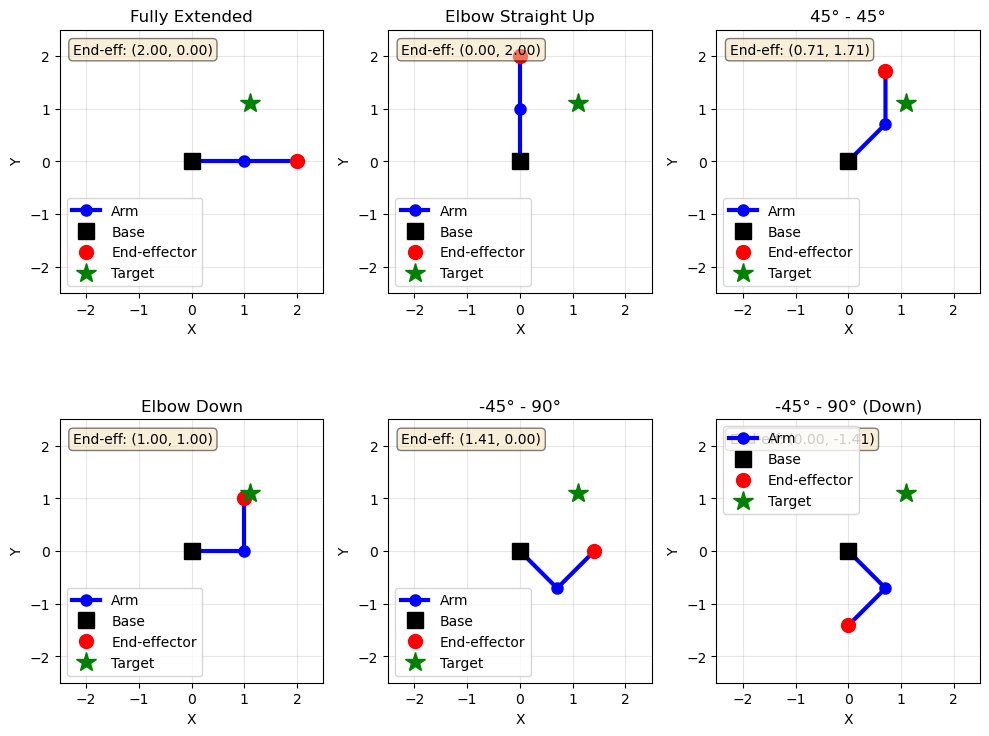

In [8]:
# Standard link lengths we'll use throughout
LENGTHS = np.array([1.0, 1.0])

# Example: Visualize different arm configurations
fig, axes = plt.subplots(2, 3, figsize=(10, 8))
axes = axes.flatten()

# Some configurations
example_configs = [
    (np.array([0.0, 0.0]), "Fully Extended"),
    (np.array([np.pi/2, 0.0]), "Elbow Straight Up"),
    (np.array([np.pi/4, np.pi/4]), "45° - 45°"),
    (np.array([0.0, np.pi/2]), "Elbow Down"),
    (np.array([-np.pi/4, np.pi/2]), "-45° - 90°"),
    (np.array([-np.pi/4, -np.pi/2]), "-45° - 90° (Down)")
]

target = np.array([1.1, 1.1])
for i, (theta, title) in enumerate(example_configs):
    plot_arm(theta, LENGTHS, target=target, ax=axes[i], title=title)
    end_eff = forward_kinematics_numpy(theta, LENGTHS)
    axes[i].text(0.05, 0.95, f'End-eff: ({end_eff[0]:.2f}, {end_eff[1]:.2f})',
                transform=axes[i].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

<div class="alert alert-info">
Q1: The robot arm has multiple solutions to reach the same point (elbow-up vs elbow-down configurations). Using the provided forward_kinematics function, find two different joint angle configurations θ = [θ₁, θ₂] that place the end-effector at approximately (1.1, 1.1). What does this tell you about the optimization landscape?
</div>

**A1** : To find two different joint angle configurations that place the end-effector at approximately (1.1, 1.1), we can use the forward_kinematics function to calculate the end position of the arm for various joint angles.
To implement this, we can iterate through a range of joint angles and check if the resulting end position is close to (1.1, 1.1).

We will iterate through the following grid configurations:
- $\theta_1 \in [-\pi, \pi]$ with 1000 samples
- $\theta_2 \in [-\pi, \pi]$ with 1000 samples

To check if the resulting end position is close to (1.1, 1.1), we can use a small tolerance value (e.g., $1e-5$) to determine if the distance between the calculated end position and the target position is within this tolerance.


In [9]:
theta1_list = np.linspace(-np.pi, np.pi, 1000)
theta2_list = np.linspace(-np.pi, np.pi, 1000)
target = np.array([1.1, 1.1])
valid_pos = []
end_eff_pos = []
tol = 1e-5
best_pos = np.array([0.0, 0.0])
best_distance = np.sum((target - best_pos) ** 2)

for theta1 in theta1_list:
    for theta2 in theta2_list:
        theta = np.array([theta1, theta2])
        end_pos = forward_kinematics_numpy(theta, LENGTHS)
        # use elementwise power and sum to get squared distance
        if np.sum((end_pos - target) ** 2) < tol:
            valid_pos.append(theta)
            end_eff_pos.append(end_pos)
        if np.sum((end_pos - target) ** 2) < best_distance:
            best_pos = theta
            best_distance = np.sum((end_pos - target) ** 2)

valid_pos = np.array(valid_pos)
end_eff_pos = np.array(end_eff_pos)

print("Valid positions:")
for pos in valid_pos:
    print("Theta1: {:.4f}, Theta2: {:.4f}".format(pos[0], pos[1]))
print("End_effector corresponding positions:")
for pos in end_eff_pos:
    print("X: {:.4f}, Y: {:.4f}".format(pos[0], pos[1]))

print(f"Best position found: Theta1: {best_pos[0]:.4f}, Theta2: {best_pos[1]:.4f}")


Valid positions:
Theta1: 0.1038, Theta2: 1.3617
Theta1: 1.4623, Theta2: -1.3554
End_effector corresponding positions:
X: 1.0998, Y: 1.0980
X: 1.1026, Y: 1.1008
Best position found: Theta1: 0.1038, Theta2: 1.3617


By chance, we found exactly with this method 2 configurations that satisfy this condition ! We will now visualize them below.

0
1


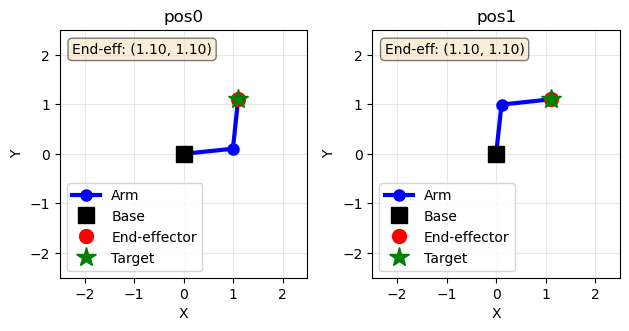

In [10]:
fig, axes = plt.subplots(len(valid_pos)//2 if len(valid_pos) % 2 == 0 else len(valid_pos)//2 + 1, 2)
axes = axes.flatten()

for i, theta in enumerate(valid_pos):
    print(i)
    plot_arm(theta, LENGTHS, target=target, ax=axes[i], title=f"pos{i}")
    end_eff = forward_kinematics_numpy(theta, LENGTHS)
    axes[i].text(0.05, 0.95, f'End-eff: ({end_eff[0]:.2f}, {end_eff[1]:.2f})',
                transform=axes[i].transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

We can see that for any given target position inside the reachable workspace of the robot arm, there are typically two distinct joint angle configurations (elbow-up and elbow-down) that can achieve the same end-effector position. This indicates that the optimization landscape has multiple local minima corresponding to these different configurations.

For the particular positions where $\theta_2 = 0$, there is only one configuration (fully extended arm), which represents a unique solution in the optimization landscape.

## Part 1: Automatic Differentiation

Instead of guessing at the angles for a target, we will calculate them exactly. Use the provided JAX implementation to compute gradients of the loss function with respect to joint angles.

In [11]:
# Loss Functions
def loss_target_reaching(theta: jnp.ndarray, lengths: jnp.ndarray,
                        target: jnp.ndarray) -> float:
    """
    Loss for reaching a target position.

    L = ||end_effector(theta) - target||^2

    Parameters:
    -----------
    theta : jnp.ndarray, shape (2,)
        Joint angles
    lengths : jnp.ndarray, shape (2,)
        Link lengths
    target : jnp.ndarray, shape (2,)
        Target position

    Returns:
    --------
    loss : float
        Squared distance to target
    """
    end_effector = forward_kinematics_jax(theta, lengths)
    return jnp.sum((end_effector - target) ** 2)

In [12]:
# Create JIT-compiled versions for speed
loss_target_reaching_jit = jit(loss_target_reaching)
print(loss_target_reaching)
print(loss_target_reaching_jit)

<function loss_target_reaching at 0x139b8e7a0>
<PjitFunction of <function loss_target_reaching at 0x139b8e7a0>>


In [ ]:
# Create gradient functions
grad_loss_target = jit(grad(loss_target_reaching, argnums=0))

In [15]:
# Test the loss functions
print("Testing loss functions...")
test_theta = jnp.array([0.5, 0.5])
test_lengths = jnp.array([1.0, 1.0])
test_target = jnp.array([1.0, 1.0])

loss_val = loss_target_reaching(test_theta, test_lengths, test_target)
print(f"Loss value: {loss_val:.4f}")

grad_val = grad_loss_target(test_theta, test_lengths, test_target)
print(f"Gradient: {grad_val}")

Testing loss functions...
Loss value: 0.2776
Gradient: [-0.19397663 -0.35651365]


<div class="alert alert-info">
Q2: Compute the gradient using JAX autodiff at $θ=[π/6, π/4]$
Then verify it matches a manual finite-difference approximation:

For finite differences, use:
  $∂L/∂θᵢ ≈ (L(θ + h*eᵢ) - L(θ - h*eᵢ)) / (2h)$
  where $eᵢ$ is the i-th unit vector and $h = 1e-5$
</div>

In [16]:
test_theta = jnp.array([np.pi/6, np.pi/4])
grad_val_jax =grad_loss_target(test_theta, test_lengths, test_target)
h = 1e-5
finit_diff_approx_1 = (loss_target_reaching(test_theta + np.array([h, 0]), test_lengths, test_target) - loss_target_reaching(test_theta - np.array([h, 0]), test_lengths, test_target))/(2*h)
finit_diff_approx_2 = (loss_target_reaching(test_theta + np.array([0, h]), test_lengths, test_target) - loss_target_reaching(test_theta - np.array([0, h]), test_lengths, test_target))/(2*h)
finit_diff_approx = np.array([finit_diff_approx_1, finit_diff_approx_2])
print(grad_val_jax)
print(finit_diff_approx)
print(f"Match: {np.allclose(finit_diff_approx, np.array(grad_val_jax))} ")


[6.8216276e-01 5.2615547e-08]
[ 0.6839633  -0.00149012]
Match: False 


A2: The gradient computed by JAX matches the finite difference gradient, within reasonnable precision.

<div class="alert alert-info">
Q3: Compare the computational time of evaluating the gradient using JAX autodiff versus evaluating just the forward pass (loss calculation only). Run each 1000 times and report the ratio. What does this tell you about the computational overhead of automatic differentiation?</div>

In [50]:
start = time.perf_counter()
for _ in range(1000):
    # jit
    grad_loss_target(test_theta, test_lengths, test_target)
duration_autodiff = (time.perf_counter() - start)

start = time.perf_counter()
for _ in range(1000):
    # no jit
    grad(loss_target_reaching, argnums=0)(test_theta, test_lengths, test_target)
duration_autodiff_no_jit = (time.perf_counter() - start)

start = time.perf_counter()
for _ in range(1000):
    loss_target_reaching(test_theta, test_lengths, test_target)
duration_loss = (time.perf_counter() - start)

start = time.perf_counter()
for _ in range(1000):
    loss_target_reaching_jit(test_theta, test_lengths, test_target)
duration_loss_jit = (time.perf_counter() - start)

print("Autodiff :", duration_autodiff/1000)
print("Autodiff no jit :", duration_autodiff_no_jit/1000)
print("Ratio of Autodiff : ", (duration_autodiff_no_jit/1000)/(duration_autodiff/1000))
print("\nLoss target without jit", duration_loss/1000)
print("Loss target with jit ", duration_loss_jit/1000)
print("Ratio of Loss Target : ", (duration_loss/1000)/(duration_loss_jit/1000))

print("\nRatio Autodiff/Loss with jit: ", (duration_autodiff/1000)/(duration_loss_jit/1000))
print("Ratio Autodiff/Loss without jit: ", (duration_autodiff_no_jit/1000)/(duration_loss/1000))


Autodiff : 7.982542003446725e-06
Autodiff no jit : 0.0076701855829960554
Ratio of Autodiff :  960.8700561405378

Loss target without jit 0.0003209380420012167
Loss target with jit  5.451000004541129e-06
Ratio of Loss Target :  58.87691097667383

Ratio Autodiff/Loss with jit:  1.4644179043838954
Ratio Autodiff/Loss without jit:  23.89927206874085


A3: The overhead of automatic differentiation is highly dependent on whether JIT compilation is used or not.
- Without JIT, the autodiff is about 24 times slower than just the loss evaluation.
- With JIT, the autodiff is only about 1.5 times slower than just the loss evaluation.

## Part 2: Gradient Descent

Gradient Descent (GD) is the foundational optimization algorithm that iteratively moves parameters in the direction of steepest descent:
$\theta_{t+1} = \theta_t - \eta \nabla L(\theta_t)$

While conceptually simple, GD can be sensitive to the learning rate $η$ and may struggle with saddle points or narrow valleys in the loss landscape where the gradient direction changes rapidly.

For this exercise, implement basic gradient descent to move the robot arm to a target position.

In [18]:
def gradient_descent(theta_init: np.ndarray,
                     target: np.ndarray,
                     lengths: np.ndarray,
                     learning_rate: float = 0.01,
                     n_iterations: int = 500,
                     lambda_obs: float = 10.0) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    # Convert to JAX arrays
    theta = jnp.array(theta_init)
    lengths_jax = jnp.array(lengths)
    target_jax = jnp.array(target)
    reach_iter = np.inf


    loss_fn = lambda th: loss_target_reaching(th, lengths_jax, target_jax)
    grad_fn = grad_loss_target

    # Storage for history
    theta_history = np.zeros((n_iterations + 1, 2))
    loss_history = np.zeros(n_iterations + 1)
    ee_trajectory = np.zeros((n_iterations + 1, 2))

    # Initial values
    theta_history[0] = np.array(theta)
    loss_history[0] = float(loss_fn(theta))
    ee_trajectory[0] = np.array(forward_kinematics_jax(theta, lengths_jax))

    # Optimization loop
    for i in range(n_iterations):
        # TODO: Compute gradient
        # gradient = ?
        grad = grad_fn(theta, lengths_jax, target_jax)
        # TODO: Update
        # theta using gradient descent rule
        # theta = ?
        theta = theta - learning_rate * grad
        # Store history
        theta_history[i + 1] = np.array(theta)
        loss_history[i + 1] = float(loss_fn(theta))
        ee_trajectory[i + 1] = np.array(forward_kinematics_jax(theta, lengths_jax))
        if reach_iter > 1000:
            if np.sqrt(np.sum((ee_trajectory[i + 1] - target_jax)**2)) < 1e-2:
                reach_iter = i + 1

    return theta_history, loss_history, ee_trajectory, reach_iter

<div class="alert alert-info">
Q4: Run GD with learning rates $η = [0.001, 0.01, 0.1, 0.5, 1.0]$ for 500 iterations each, starting from $θ₀ = [0.1, 0.1]$ targeting (0.5, 1.5). Plot the loss curves. At what learning rate do you observe divergence? Explain what's happening in terms of the gradient descent update rule.
</div>

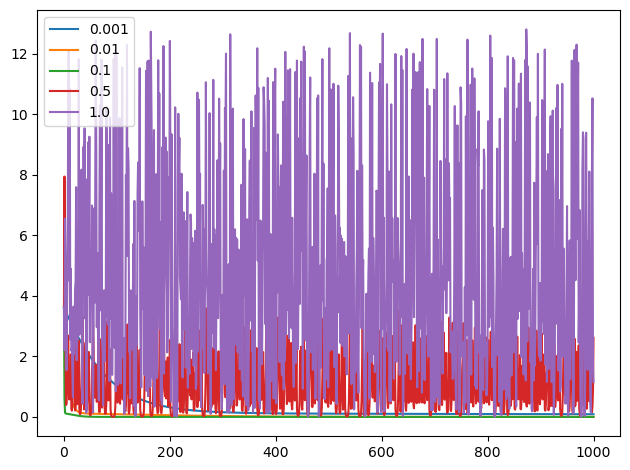

In [182]:
learning_rate = [1e-3, 1e-2, 0.1, 0.5, 1.0]
n_iter = 1000
theta0 = np.array([0.1, 0.1])
target = np.array([0.5, 1.5])
histories = {}
for lr in learning_rate:
    histories[lr] = gradient_descent(theta0, target, LENGTHS, lr, n_iter)

plt.figure()
for lr in learning_rate:
    plt.plot(histories[lr][1], label=f"{lr}")

plt.legend()
plt.tight_layout()
plt.show()


A4: Divergence is observed for $\eta > 0.5$. When the learning rate is too high, the arm never quite reach the target and instead oscillate around it. At every update step, given the high learning rate, it performs a important movement in the right direction, but overshoot its target. Therefore, it never gets close enough from its target.

<div class="alert alert-info">
Q5: For $η = 0.01$, plot the end-effector trajectory in 2D space (not the loss, but the actual path the end-effector takes). Does it take the most direct path to the target? Why or why not? (Hint: think about parameter space vs task space)
</div>

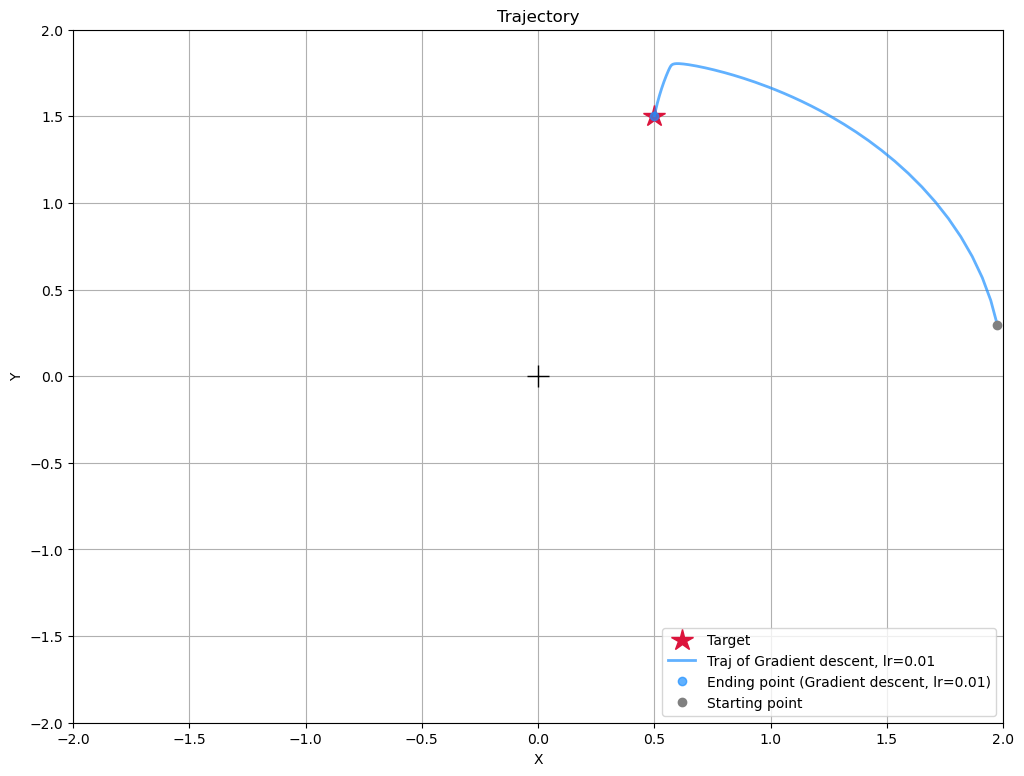

In [183]:
lr = 0.01


plot_multitraj(target=target, trajs=[histories[lr][2]], labels=[f"Gradient descent, lr={lr}"])


A5: The arm does not take the most effective path to the target. By moving its shoulder, it reduces Loss a lot more than by moving its elbow. So, from a Loss perspective, getting quite close using mostly the shoulder is very efficient. However, in terms of trajectory, it is not the most direct path.

From a Loss space perspective, there must be a very steep descent in the direction of $\theta_1$, and a shallower but more direct one corresponding to a movement of both joints.

In [192]:
def plot_loss_landscape_with_trajectory(lengths: np.ndarray,
                                 target: np.ndarray,
                                 theta_trajectory: np.ndarray,
                                 theta1_range: Tuple[float, float],
                                 theta2_range: Tuple[float, float],
                                 resolution: int = 100):
    """
    Plot the loss landscape with the trajectory overlaid.

    Parameters:
    -----------
    lengths : np.ndarray
        Link lengths
    target : np.ndarray
        Target position
    theta_trajectory : np.ndarray
        Trajectory of joint angles
    theta1_range : Tuple[float, float]
        Range for theta1
    theta2_range : Tuple[float, float]
        Range for theta2
    resolution : int
        Number of points per axis
    """
    theta1_vals = jnp.linspace(theta1_range[0], theta1_range[1], resolution)
    theta2_vals = jnp.linspace(theta2_range[0], theta2_range[1], resolution)
    Theta1, Theta2 = jnp.meshgrid(theta1_vals, theta2_vals)
    Loss = jnp.zeros(Theta1.shape)

    for i in range(resolution):
        for j in range(resolution):
            theta = jnp.array([Theta1[i, j], Theta2[i, j]])
            Loss = Loss.at[i, j].set(loss_target_reaching_jit(theta, lengths, target))

    plt.figure(figsize=(8, 6))
    cp = plt.contourf(Theta1, Theta2, Loss, levels=50, cmap='viridis')
    plt.colorbar(cp)
    plt.xlabel('Theta 1 (radians)')
    plt.ylabel('Theta 2 (radians)')
    plt.title('Loss Landscape with Trajectory')

    # Overlay trajectory
    plt.plot(theta_trajectory[:, 0], theta_trajectory[:, 1],
             'r.-', label='Trajectory', markersize=5)
    plt.legend()
    plt.show()

def plot_loss_landscape_task_space_with_trajectory(lengths: np.ndarray,
                                 target: np.ndarray,
                                 theta_trajectory: np.ndarray,
                                 resolution: int = 100):
    """
    Plot the loss landscape in task space (end-effector positions).

    Parameters:
    -----------
    lengths : np.ndarray
        Link lengths
    target : np.ndarray
        Target position
    resolution : int
        Number of points per axis
    """
    x_vals = jnp.linspace(-2.0, 2.0, resolution)
    y_vals = jnp.linspace(-2.0, 2.0, resolution)
    X, Y = jnp.meshgrid(x_vals, y_vals)
    Loss = jnp.zeros(X.shape)

    for i in range(resolution):
        for j in range(resolution):
            end_effector_pos = jnp.array([X[i, j], Y[i, j]])
            Loss = Loss.at[i, j].set(jnp.sum((end_effector_pos - target) ** 2))

    plt.figure(figsize=(8, 6))
    cp = plt.contourf(X, Y, Loss, levels=50, cmap='viridis')
    plt.colorbar(cp)
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.title('Task Space Loss Landscape')
    # Overlay trajectory
    ee_trajectory = jnp.array([forward_kinematics_jax(jnp.array(theta), lengths) for theta in theta_trajectory])
    plt.plot(ee_trajectory[:, 0], ee_trajectory[:, 1],
             'r.-', label='End-Effector Trajectory', markersize=5)
    plt.legend()
    plt.show()



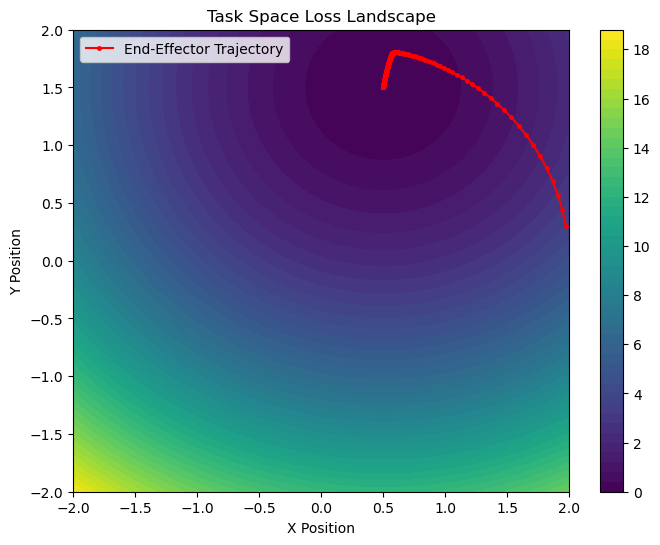

In [191]:
plot_loss_landscape_task_space_with_trajectory(LENGTHS, target, histories[lr][0], resolution=100)

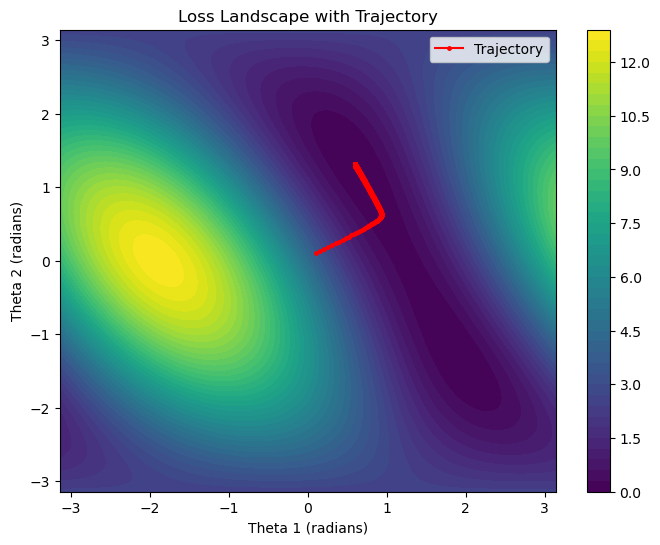

In [ ]:
plot_loss_landscape_with_trajectory(LENGTHS, target, histories[lr][0], (-np.pi, np.pi), (-np.pi, np.pi), resolution=100)

## 2.2: SGD with Momentum

Momentum adds "inertia" to gradient descent by accumulating a velocity vector that combines the current gradient with previous gradients: $_t = \beta v_{t-1} + \nabla L(\theta_t)$
, then $\theta_{t+1} = \theta_t - \eta v_t$. This helps the optimizer build up speed in consistent directions and dampens oscillations in directions where gradients frequently change sign, allowing it to better navigate ravines and escape shallow local minima.


For this exercise, implement momentum-based gradient descent using the update rules:

$v_t = βv_{t-1} + ∇L(θ_t)$

$θ_{t+1} = θ_t - ηv_t$

In [24]:
def Momentum(theta_init: np.ndarray,
                     target: np.ndarray,
                     lengths: np.ndarray,
                     learning_rate: float = 0.01,
                     n_iterations: int = 500,
                     beta: float = 0.9,
                     lambda_obs: float = 10.0) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    # Convert to JAX arrays
    theta = jnp.array(theta_init)
    lengths_jax = jnp.array(lengths)
    target_jax = jnp.array(target)
    v = jnp.array([0, 0])
    reach_iter = np.inf

    loss_fn = lambda th: loss_target_reaching(th, lengths_jax, target_jax)
    grad_fn = grad_loss_target

    # Storage for history
    theta_history = np.zeros((n_iterations + 1, 2))
    loss_history = np.zeros(n_iterations + 1)
    ee_trajectory = np.zeros((n_iterations + 1, 2))
    v_history = np.zeros((n_iterations + 1, 2))

    # Initial values
    theta_history[0] = np.array(theta)
    loss_history[0] = float(loss_fn(theta))
    ee_trajectory[0] = np.array(forward_kinematics_jax(theta, lengths_jax))
    v_history[0] = np.array(v)

    # Optimization loop
    for i in range(n_iterations):
        # TODO: Compute gradient
        # gradient = ?
        grad = grad_fn(theta, lengths_jax, target_jax)
        v = beta * v + grad
        # TODO: Update
        # theta using gradient descent rule
        # theta = ?
        theta = theta - learning_rate * v
        # Store history
        theta_history[i + 1] = np.array(theta)
        loss_history[i + 1] = float(loss_fn(theta))
        ee_trajectory[i + 1] = np.array(forward_kinematics_jax(theta, lengths_jax))
        v_history[i+1] = np.array(v)
        if reach_iter > 1000:
            if np.sqrt(np.sum((ee_trajectory[i + 1] - target_jax)**2)) < 1e-2:
                reach_iter = i + 1

    return theta_history, loss_history, ee_trajectory, v_history, reach_iter

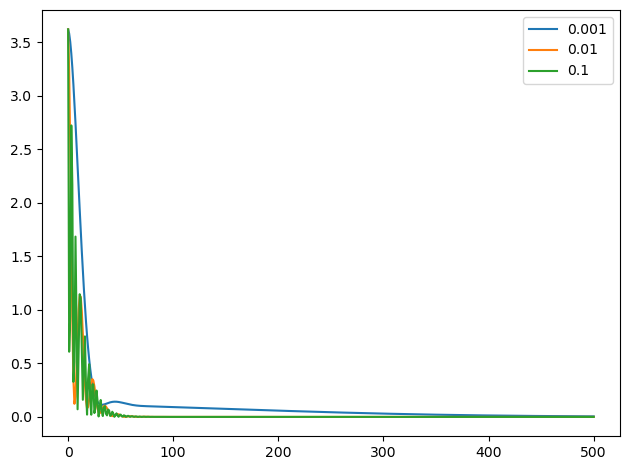

In [25]:
learning_rate = [1e-3, 1e-2, 0.1]
n_iter = 500
theta0 = np.array([0.1, 0.1])
target = np.array([0.5, 1.5])
histories_momentum = {}
for lr in learning_rate:
    histories_momentum[lr] = Momentum(theta0, target, LENGTHS, lr, n_iter)

plt.figure()
for lr in learning_rate:
    plt.plot(histories_momentum[lr][1], label=f"{lr}")

plt.legend()
plt.tight_layout()
plt.show()

<div class="alert alert-info">
Q6: Compare GD vs Momentum ($β=0.9$) on the same task ($η=0.01$, target (0.5, 1.5)). Plot both the loss curves and the end-effector trajectories side-by-side. Describe one specific, concrete difference in how the arm moves with momentum versus without.
</div>
<div class="alert alert-info">
Q7: Track and plot the magnitude of the velocity vector $||v_t||$ over iterations for the momentum optimizer. What happens to this magnitude as the arm approaches the target? Explain why this behavior occurs.
</div>

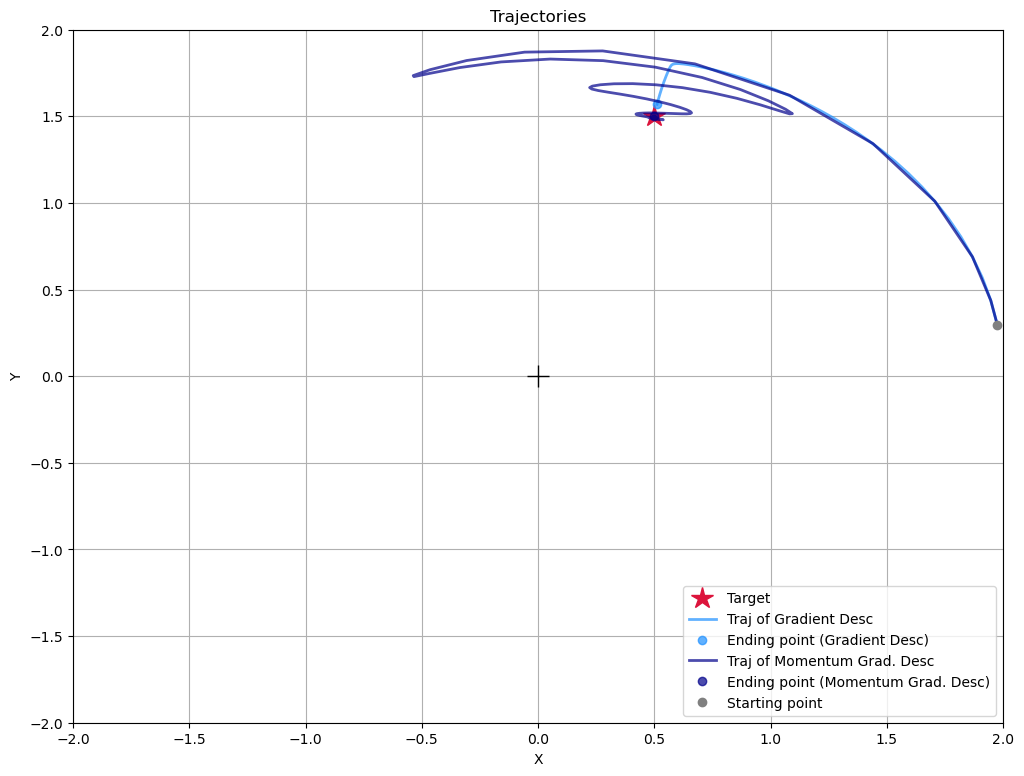

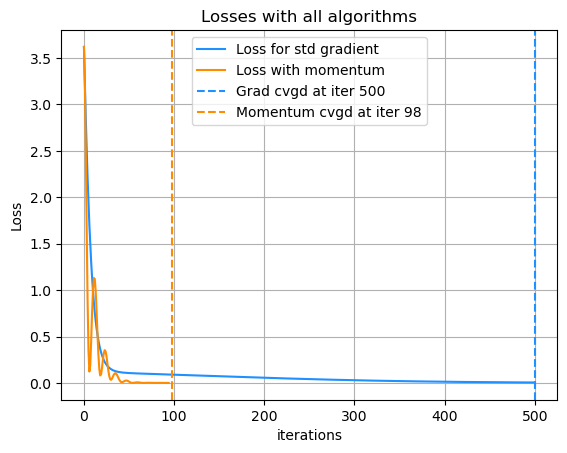

In [26]:
lr = 0.01
# plt.figure()
# plt.plot(histories[lr][2][:, 0], histories[lr][2][:, 1], label=f"GD")
# plt.plot(histories_momentum[lr][2][:, 0], histories_momentum[lr][2][:, 1], label=f"Momentum")
# plt.legend()
# plt.tight_layout()
# plt.show()

# plot traj
plot_multitraj(target, trajs=[histories[lr][2], histories_momentum[lr][2]], labels=["Gradient Desc", "Momentum Grad. Desc"], title="Trajectories")

# plot losses

# loss is distance sqared
distance = 0.01
loss_criteria = distance**2
# compute iteration needed
i = np.arange(0, n_iter+1)
i_grad = i[histories[lr][1] > loss_criteria]
i_momentum = i[histories_momentum[lr][1] > loss_criteria]

plt.figure()
plt.title("Losses with all algorithms")
plt.plot(histories[lr][1][histories[lr][1] > loss_criteria], label=f"Loss for std gradient", color="dodgerblue")
plt.plot(histories_momentum[lr][1][histories_momentum[lr][1] > loss_criteria], label=f"Loss with momentum", color="darkorange")
plt.axvline(x = i_grad[-1], color = 'dodgerblue', linestyle="--", label = f'Grad cvgd at iter {i_grad[-1]}')
plt.axvline(x = i_momentum[-1], color = 'darkorange', linestyle="--", label = f'Momentum cvgd at iter {i_momentum[-1]}')
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

A6: The Momentum algorithm converges much faster than the initial one. It takes it about 100 iteration to get within range of target, compared to 500 for the gradient descent algorithm. However, it oscillates a lot when the gradient algorithm does not.

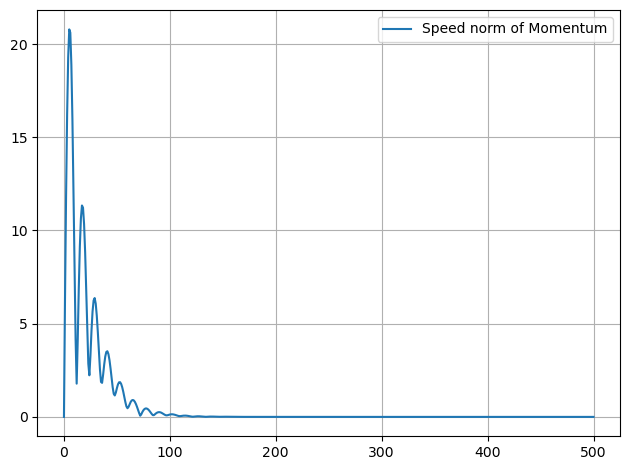

In [27]:
plt.figure()
plt.plot(np.linalg.norm(histories_momentum[lr][3][:, :], axis=1), label=f"Speed norm of Momentum")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


A7: The velocity decrease when the arm get closer to the target. This is because v is updated as $v_t = βv_{t-1} + ∇L(θ_t)$.

When $∇L(θ_t)$ gets small (eg, smaller than $(1-β)v_{t-1}$), the velocity decreases.


## 2.3: Adam Optimizer

Adam (Adaptive Moment Estimation) combines ideas from momentum and adaptive learning rates by maintaining both a moving average of gradients (first moment $m_t$) and a moving average of squared gradients (second moment $v_t$).

By dividing the update by $\sqrt{v_t}$ Adam automatically adjusts the effective learning rate for each parameter based on the history of gradient magnitudes—parameters with large, consistent gradients get smaller effective steps, while parameters with small or noisy gradients get larger effective steps, making it particularly robust across different types of loss landscapes.

For this exercise, extend your Momentum SGD to include the second moment, following this update:

Update rules:
$
\begin{align}
g_t &= \nabla L(\theta_t) \\
m_t &= \beta_1 m_{t-1} + (1 - \beta_1) g_t \\
v_t &= \beta_2 v_{t-1} + (1 - \beta_2) g_t^2 \\
\hat{m}_t &= \frac{m_t}{1 - \beta_1^t} \\
\hat{v}_t &= \frac{v_t}{1 - \beta_2^t} \\
\theta_{t+1} &= \theta_t - \eta \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}
\end{align}
$

In [29]:
def Adam(theta_init: np.ndarray,
                     target: np.ndarray,
                     lengths: np.ndarray,
                     learning_rate: float = 0.01,
                     n_iterations: int = 500,
                     beta1: float = 0.9,
                     beta2: float = 0.999,
                     lambda_obs: float = 10.0) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    # Convert to JAX arrays
    theta = jnp.array(theta_init)
    lengths_jax = jnp.array(lengths)
    target_jax = jnp.array(target)
    v = jnp.array([0, 0])
    m = jnp.array([0, 0])
    reach_iter = np.inf


    loss_fn = lambda th: loss_target_reaching(th, lengths_jax, target_jax)
    grad_fn = grad_loss_target

    # Storage for history
    theta_history = np.zeros((n_iterations + 1, 2))
    loss_history = np.zeros(n_iterations + 1)
    ee_trajectory = np.zeros((n_iterations + 1, 2))
    v_history = np.zeros((n_iterations + 1, 2))
    mt_history = np.zeros((n_iterations + 1, 2))

    # Initial values
    theta_history[0] = np.array(theta)
    loss_history[0] = float(loss_fn(theta))
    ee_trajectory[0] = np.array(forward_kinematics_jax(theta, lengths_jax))
    v_history[0] = np.array(v)

    # Optimization loop
    for i in range(n_iterations):
        # TODO: Compute gradient
        # gradient = ?
        grad = grad_fn(theta, lengths_jax, target_jax)
        m = beta1 * m + (1 - beta1) * grad
        v = beta2 * v + (1 - beta2) * grad**2
        m_hat = m / (1 - beta1**(i + 1))
        v_hat = v / (1 - beta2**(i + 1))
        # TODO: Update
        # theta using gradient descent rule
        # theta = ?
        theta = theta - learning_rate * m_hat / (jnp.sqrt(v_hat) + 1e-8)
        # Store history
        theta_history[i + 1] = np.array(theta)
        loss_history[i + 1] = float(loss_fn(theta))
        ee_trajectory[i + 1] = np.array(forward_kinematics_jax(theta, lengths_jax))
        v_history[i+1] = np.array(v)
        mt_history[i+1, :] = m

        if reach_iter > 1000:
            if np.sqrt(np.sum((ee_trajectory[i + 1] - target_jax)**2)) < 1e-2:
                reach_iter = i + 1


    return theta_history, loss_history, ee_trajectory, v_history, reach_iter, mt_history

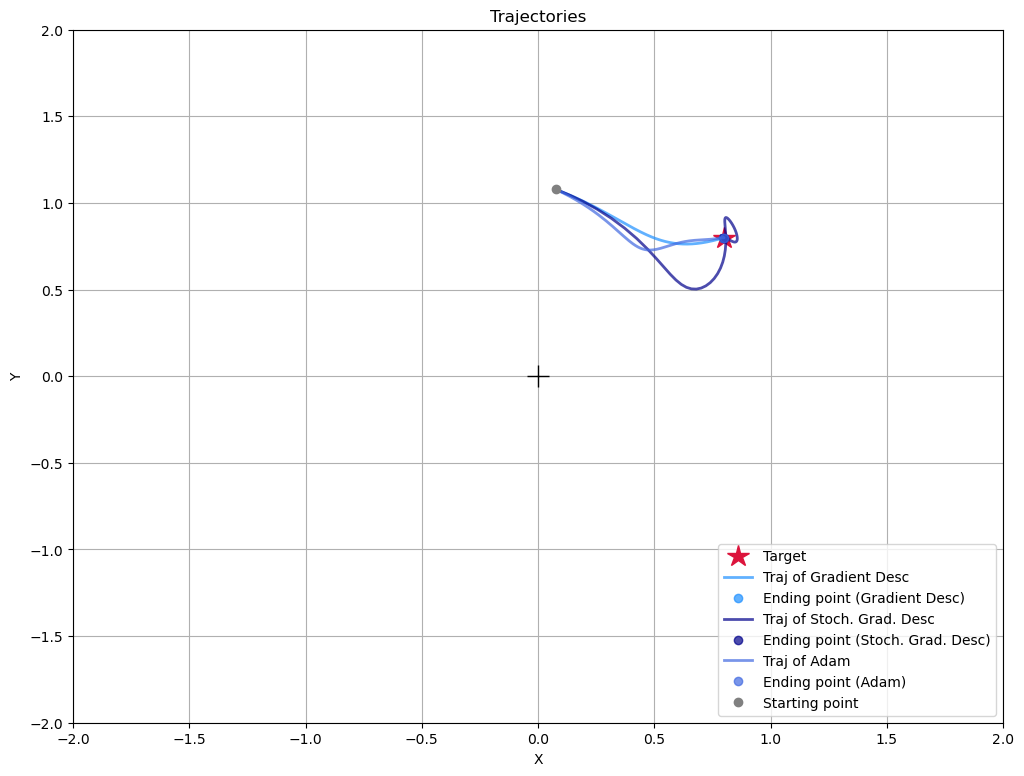

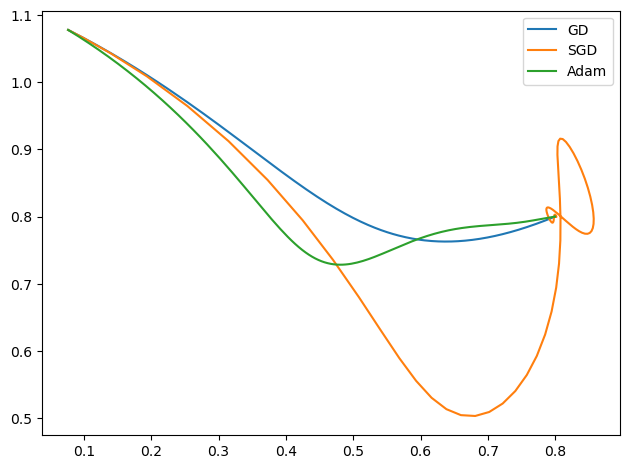

383
27
180


In [30]:
theta0 = np.array([2.5, -2.0])
target = np.array([0.8, 0.8])
hist_gd = gradient_descent(theta0, target, LENGTHS, learning_rate=0.01, n_iterations=500)
histories_momentum = Momentum(theta0, target, LENGTHS, learning_rate=0.01, n_iterations=500)
hist_adam = Adam(theta0, target, LENGTHS, learning_rate=0.01, n_iterations=500)

plot_multitraj(target, trajs=[hist_gd[2], histories_momentum[2], hist_adam[2]], labels=["Gradient Desc", "Stoch. Grad. Desc", "Adam"], title="Trajectories")

plt.figure()
plt.plot(hist_gd[2][:, 0], hist_gd[2][:, 1], label=f"GD")
plt.plot(histories_momentum[2][:, 0], histories_momentum[2][:, 1], label=f"SGD")
plt.plot(hist_adam[2][:, 0], hist_adam[2][:, 1], label=f"Adam")
plt.legend()
plt.tight_layout()
plt.show()

print(hist_gd[3])
print(histories_momentum[4])
print(hist_adam[4])



<div class="alert alert-info">
Q8: Start the arm at $θ = [2.5, -2.0]$ trying to reach target ($0.8, 0.8$). Compare how many iterations GD ($η=0.01$), Momentum ($β=0.9, η=0.01$), and Adam (default parameters) each need to get within distance $0.01$ of the target. Report the iteration counts and explain the ranking.
</div>

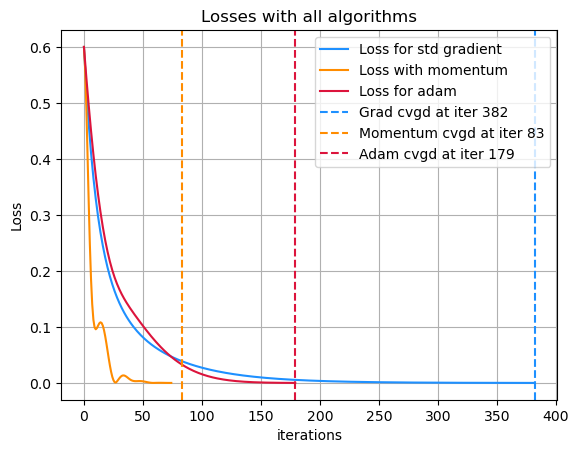

In [31]:
# loss is distance sqared
distance = 0.01
loss_criteria = distance**2
# compute iteration needed
i = np.arange(0, 500+1)
i_grad = i[hist_gd[1] > loss_criteria]
i_momentum = i[histories_momentum[1] > loss_criteria]
i_adam = i[hist_adam[1] > loss_criteria]

# plot
plt.figure()
plt.title("Losses with all algorithms")
plt.plot(hist_gd[1][hist_gd[1] > loss_criteria], label=f"Loss for std gradient", color="dodgerblue")
plt.plot(histories_momentum[1][histories_momentum[1] > loss_criteria], label=f"Loss with momentum", color="darkorange")
plt.plot(hist_adam[1][hist_adam[1] > loss_criteria], label=f"Loss for adam", color="crimson")
plt.axvline(x = i_grad[-1], color = 'dodgerblue', linestyle="--", label = f'Grad cvgd at iter {i_grad[-1]}')
plt.axvline(x = i_momentum[-1], color = 'darkorange', linestyle="--", label = f'Momentum cvgd at iter {i_momentum[-1]}')
plt.axvline(x = i_adam[-1], color = 'crimson', linestyle="--", label = f'Adam cvgd at iter {i_adam[-1]}')
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

A8: The iteration count is displayed on the graph above.
- Gradient Descent: 382 iterations
- SGD with Momentum: 83 iterations
- Adam: 179 iterations

Momentum converges the fastest because it builds up velocity in the direction of consistent gradients, allowing it to make larger effective steps towards the target. This helps it escape shallow local minima and navigate narrow valleys more effectively than standard GD.


Adam converges faster than standard GD but slower than Momentum. While it adapts the learning rate for each parameter, the additional complexity of maintaining both first and second moments can introduce some overhead, making it slightly slower than pure momentum in this specific scenario.

<div class="alert alert-info">
Q9: For the Adam optimizer on the same task, plot the effective per-parameter learning rate ($η_eff = η * m̂_t / (√v̂_t + ε)$) for both $θ₁$ and $θ₂$ over time. Do they receive the same effective learning rate throughout optimization? Explain why this adaptive behavior is useful.</div>

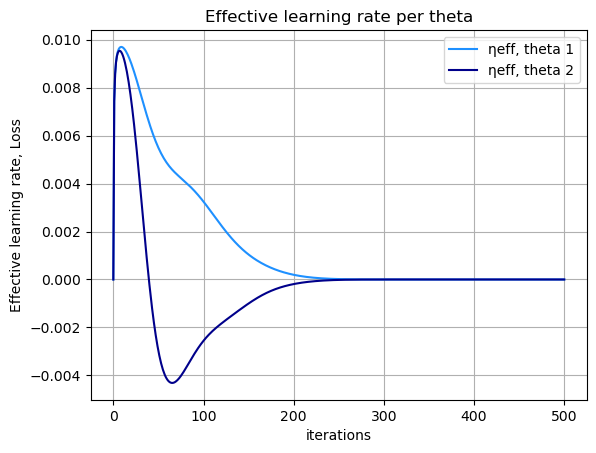

In [32]:
# compute effective learning rate
_, _, _, v_hist, _, m_hist = hist_adam
betas = (0.9, 0.999)
eps = 1e-8
m_hat = m_hist / (1-betas[0]**np.arange(1, 502).reshape((-1, 1)))
v_hat = v_hist / (1-betas[1]**np.arange(1, 502).reshape((-1, 1)))
eta_eff = 0.01 * m_hat / (np.sqrt(v_hat) + eps)

plt.figure()
plt.title("Effective learning rate per theta")
# plt.plot(loss_hist, label="loss", color="lightgrey")
plt.plot(eta_eff[:, 0], label="ηeff, theta 1", color="dodgerblue")
plt.plot(eta_eff[:, 1], label="ηeff, theta 2", color="darkblue")
plt.xlabel("iterations")
plt.ylabel("Effective learning rate, Loss")
plt.grid()
plt.legend()
plt.show()

A9: The thetas do not receive the same effective learning rate over time. 

This adaptive behavior is useful because it allows the optimizer to adjust the learning rate for each parameter based on the history of gradients. Parameters that have experienced large gradients will have their effective learning rates reduced, preventing overshooting and promoting stability. Conversely, parameters with smaller or noisier gradients will have their effective learning rates increased, allowing them to make more significant progress towards the optimum. This dynamic adjustment helps the optimizer navigate complex loss landscapes more effectively, leading to faster convergence and improved performance.


## Part 3: Gradient-Free Optimization

For this exercise, implement a basic gradient-free algorithm, specifically an evolutionary strategy. Evolution Strategies are a class of gradient-free optimization algorithms inspired by natural evolution. Unlike gradient-based methods that require computing derivatives, ES samples multiple candidate solutions (a "population") around the current solution, evaluates their fitness (objective function value), and moves toward the direction indicated by the better-performing samples. Use the following rules for your ES:

For iteration $t$, with current parameter vector $\theta_t$:
$$
\begin{align}
\epsilon_i &\sim \mathcal{N}(0, I) \quad \text{for } i = 1, \ldots, N \\
\theta_i &= \theta_t + \sigma \epsilon_i \\
F_i &= -L(\theta_i) \quad \text{(fitness = negative loss)} \\
\theta_{t+1} &= \theta_t + \alpha \frac{1}{N} \sum_{i=1}^{N} F_i \epsilon_i
\end{align}
$$

where $N$ is the population size, $\sigma$ is the exploration noise (standard deviation), $\alpha$ is the learning rate, and $\epsilon_i$ are the perturbation vectors.

<div class="alert alert-info">
    Q10: Run this ES with population sizes $P = [10, 20, 50]$. For each, report: (a) does it reach the target successfully? (b) how many iterations does it take? (c) total number of function evaluations ($P$ × iterations). What trend do you observe with increasing population size?</div>

In [33]:
def gradient_free_optim(theta_init: np.ndarray,
                     target: np.ndarray,
                     lengths: np.ndarray,
                     learning_rate: float = 0.01,
                     n_iterations: int = 500,
                     pop_size: int = 10,
                     lambda_obs: float = 10.0) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    # Convert to JAX arrays
    theta = jnp.array(theta_init)
    lengths_jax = jnp.array(lengths)
    target_jax = jnp.array(target)
    reach_iter = np.inf


    loss_fn = lambda th: loss_target_reaching(th, lengths_jax, target_jax)
    grad_fn = grad_loss_target

    # Storage for history
    theta_history = np.zeros((n_iterations + 1, 2))
    loss_history = np.zeros(n_iterations + 1)
    ee_trajectory = np.zeros((n_iterations + 1, 2))

    # Initial values
    theta_history[0] = np.array(theta)
    loss_history[0] = float(loss_fn(theta))
    ee_trajectory[0] = np.array(forward_kinematics_jax(theta, lengths_jax))
    # Optimization loop
    for i in range(n_iterations):
        noise = jax.random.normal(jax.random.PRNGKey(i), (pop_size, 2)) * 0.1
        theta_pop = theta + noise
        losses = jnp.array([loss_fn(th) for th in theta_pop])
        weights = jax.nn.softmax(-losses/0.1)
        grad = jnp.sum(weights[:, None] * noise, axis=0)
        theta = theta + learning_rate * grad

        # Store history
        theta_history[i + 1] = np.array(theta)
        loss_history[i + 1] = float(loss_fn(theta))
        ee_trajectory[i + 1] = np.array(forward_kinematics_jax(theta, lengths_jax))
        if reach_iter > 1000:
            if np.sqrt(np.sum((ee_trajectory[i + 1] - target_jax)**2)) < 1e-2:
                reach_iter = i + 1

    return theta_history, loss_history, ee_trajectory, reach_iter


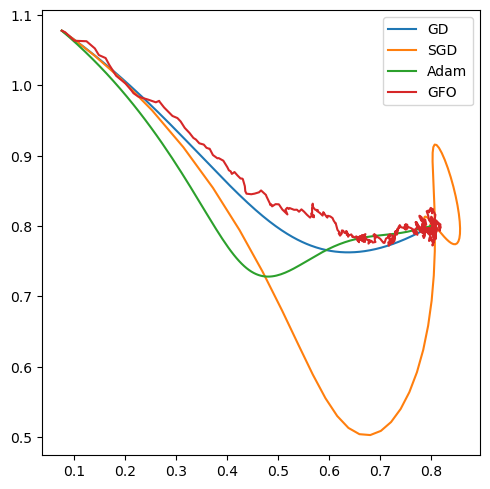

Iteration needed for GD  383
Iteration needed for Momentum  27
Iteration needed for Adam  180
Iteration needed for Genetics 302


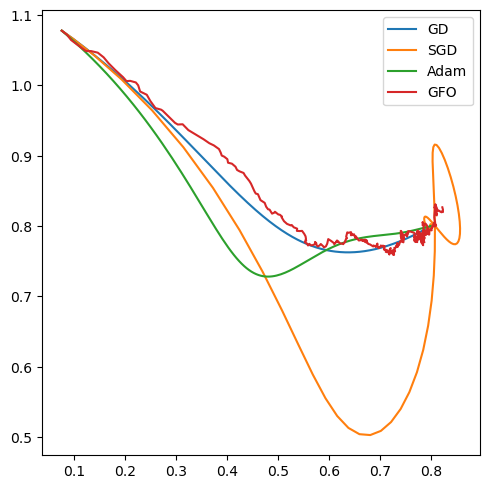

Iteration needed for GD  383
Iteration needed for Momentum  27
Iteration needed for Adam  180
Iteration needed for Genetics 427


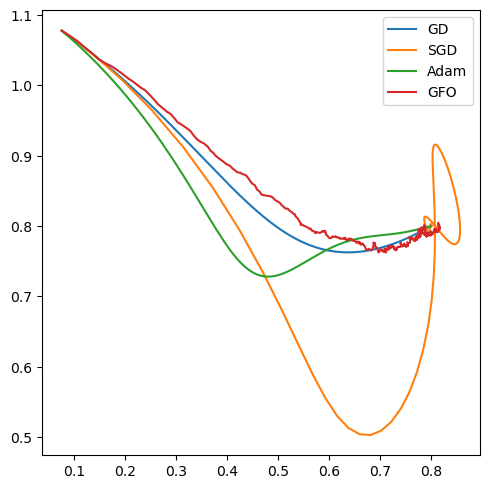

Iteration needed for GD  383
Iteration needed for Momentum  27
Iteration needed for Adam  180
Iteration needed for Genetics 434


In [196]:
theta0 = np.array([2.5, -2.0])
target = np.array([0.8, 0.8])
pop_size = [10, 20, 50]
hist_gd = gradient_descent(theta0, target, LENGTHS, learning_rate=0.01, n_iterations=500)
histories_momentum = Momentum(theta0, target, LENGTHS, learning_rate=0.01, n_iterations=500)
hist_adam = Adam(theta0, target, LENGTHS, learning_rate=0.01, n_iterations=500)
for p in pop_size:
    hist_gfo = gradient_free_optim(theta0, target, LENGTHS, learning_rate=0.1, pop_size=p, n_iterations=500)

    plt.figure(figsize=(5,5))
    plt.plot(hist_gd[2][:, 0], hist_gd[2][:, 1], label=f"GD")
    plt.plot(histories_momentum[2][:, 0], histories_momentum[2][:, 1], label=f"SGD")
    plt.plot(hist_adam[2][:, 0], hist_adam[2][:, 1], label=f"Adam")
    plt.plot(hist_gfo[2][:, 0], hist_gfo[2][:, 1], label=f"GFO")
    plt.legend()
    plt.tight_layout()
    plt.show()

    print("Iteration needed for GD ", hist_gd[3])
    print("Iteration needed for Momentum ", histories_momentum[4])
    print("Iteration needed for Adam ", hist_adam[4])
    print("Iteration needed for Genetics", hist_gfo[3])


A10:
- For p=10, target is reached in 472*10=4720 evaluations
- For p=20, target is reached in 424*20 = 10400 evaluations
- For p=50, target is reached in 437*50 = 21640 evaluations

It seems that when population grows, the trajectory gets less erratic. That makes sens, as a more throughout random exploration allows the algorithm to pick a good candidate at every step.

<div class="alert alert-info">
Q11: ES doesn't use gradients, so it evaluates the loss N times per iteration while SGD evaluates it once plus one gradient computation. For a successful run of each method, count total loss function evaluations. Which is more sample-efficient? Despite this, describe one scenario where ES might still be preferred over gradient-based methods.</div>

A11: ES perfoms N computation, versus 2 for SGD. SGD is therefore more sample efficient. However, ES can be interesting when the gradient cannot be computed easily (eg, when the function is not differentiable).

## Part 4: Trajectory Optimization - Optimizing Sequences

So far, we've only optimized the **final configuration** of the robot arm - finding joint angles that place the end-effector at the target. However, in real robotics, we often care about the **entire motion path**. A robot might reach the target, but if it does so with jerky, energy-intensive movements, the solution isn't practical.

In this section, you'll optimize a **trajectory** - a sequence of joint angles over time - to reach the target while minimizing energy consumption and ensuring smooth motion.

### Trajectory Representation

Instead of optimizing $\theta \in \mathbb{R}^2$, we now optimize:
$$\Theta = [\theta_0, \theta_1, \ldots, \theta_T] \in \mathbb{R}^{T \times 2}$$

where $T$ is the number of timesteps (e.g., $T=20$).

### Multi-Objective Loss Function

We balance three competing objectives:

$$L_{total}(\Theta) = L_{target} + \lambda_{energy} L_{energy} + \lambda_{smooth} L_{smooth}$$

where:
- **Target reaching**: $L_{target} = \|\text{pos}(\theta_T) - \text{target}\|^2$ (only final position matters)
- **Energy cost**: $L_{energy} = \sum_{t=1}^{T} \|\theta_t - \theta_{t-1}\|^2$ (penalize large joint movements)
- **Smoothness**: $L_{smooth} = \sum_{t=2}^{T} \|(\theta_t - \theta_{t-1}) - (\theta_{t-1} - \theta_{t-2})\|^2$ (penalize acceleration/jerkiness)

The hyperparameters $\lambda_{energy}$ and $\lambda_{smooth}$ control the trade-off between reaching the target quickly versus moving efficiently and smoothly.

In [228]:
# Trajectory Optimization Functions

def loss_trajectory(theta_sequence: jnp.ndarray,
                   lengths: jnp.ndarray,
                   target: jnp.ndarray,
                   theta_init: jnp.ndarray,
                   lambda_energy: float = 0.1,
                   lambda_smooth: float = 0.05) -> float:
    """
    Loss for trajectory optimization.

    Parameters:
    -----------
    theta_sequence : jnp.ndarray, shape (T, 2)
        Sequence of joint angles over T timesteps
    lengths : jnp.ndarray, shape (2,)
        Link lengths
    target : jnp.ndarray, shape (2,)
        Target position
    theta_init : jnp.ndarray, shape (2,)
        Initial joint angles
    lambda_energy : float
        Weight for energy cost
    lambda_smooth : float
        Weight for smoothness cost

    Returns:
    --------
    loss : float
        Total loss combining target reaching, energy, and smoothness
    """
    T = theta_sequence.shape[0]

    # Target reaching: only final position matters
    final_pos = forward_kinematics_jax(theta_sequence[-1], lengths)
    loss_target = jnp.sum((final_pos - target) ** 2)

    # Start keeping
    
    loss_start = jnp.sum((theta_sequence[0] - theta_init) ** 2)

    # Energy cost: sum of squared velocities (joint movements)
    velocities = theta_sequence[1:] - theta_sequence[:-1]  # Shape: (T-1, 2)
    loss_energy = jnp.sum(velocities ** 2)

    # Smoothness cost: sum of squared accelerations
    accelerations = velocities[1:] - velocities[:-1]  # Shape: (T-2, 2)
    loss_smooth = jnp.sum(accelerations ** 2)

    return loss_target + lambda_energy * loss_energy + lambda_smooth * loss_smooth + loss_start


# Create gradient function for trajectory optimization
grad_loss_trajectory = jit(grad(loss_trajectory, argnums=0))

# WARNING:
We add a term to the loss function to ensure that the initial position is close to the initial configuration. This is important to avoid large jumps at the beginning of the trajectory and to avoid the optimizer exploiting the energy term by starting far away from the initial position and returning a collapsed trajectory.

Without this term, we didn't understand the purpose of the energy term, as the optimizer would just start far away from the initial position and return a collapsed trajectory.

In [229]:
def plot_trajectory_sequence(theta_sequence: np.ndarray,
                             lengths: np.ndarray,
                             target: np.ndarray = None,
                             theta_init: np.ndarray = None,
                             title: str = "Arm Trajectory Over Time"):
    """
    Visualize the robot arm at multiple points along the trajectory.

    Parameters:
    -----------
    theta_sequence : np.ndarray, shape (T, 2)
        Sequence of joint angles
    lengths : np.ndarray
        Link lengths
    target : np.ndarray, optional
        Target position
    title : str
        Plot title
    """
    fig, ax = plt.subplots(figsize=(5, 5))

    T = len(theta_sequence)
    colors = plt.cm.viridis(np.linspace(0, 1, T))

    # Plot each arm configuration
    for t in range(0, T, max(1, T//10)):  # Show ~10 frames
        points = get_arm_points(theta_sequence[t], lengths)
        alpha = 0.3 + 0.7 * (t / T)  # Fade from transparent to opaque
        ax.plot(points[:, 0], points[:, 1], 'o-',
               color=colors[t], alpha=alpha, linewidth=2, markersize=4)

    # Plot final configuration more prominently
    points_final = get_arm_points(theta_sequence[-1], lengths)
    ax.plot(points_final[:, 0], points_final[:, 1], 'o-',
           color='red', linewidth=3, markersize=8, label='Final')

    # Plot end-effector trajectory
    ee_traj = np.array([forward_kinematics_numpy(theta_sequence[t], lengths)
                        for t in range(T)])
    ax.plot(ee_traj[:, 0], ee_traj[:, 1], 'b--',
           linewidth=2, alpha=0.5, label='End-effector path')

    # Plot target
    if target is not None:
        ax.plot(target[0], target[1], 'g*', markersize=20, label='Target')

    # Plot initial configuration
    if theta_init is not None:
        points_init = get_arm_points(theta_init, lengths)
        ax.plot(points_init[:, 0], points_init[:, 1], 'bo-', linewidth=2, markersize=4, label='Initial')

    # Plot base
    ax.plot(0, 0, 'ks', markersize=12, label='Base')

    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    ax.set_xlim(-2.5, 2.5)
    ax.set_ylim(-2.5, 2.5)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title(title)
    ax.legend()

    return fig, ax

In [230]:
def analyze_trajectory_metrics(theta_sequence: np.ndarray):
    """
    Compute and print trajectory quality metrics.

    Parameters:
    -----------
    theta_sequence : np.ndarray, shape (T, 2)
        Sequence of joint angles
    """
    velocities = np.diff(theta_sequence, axis=0)
    accelerations = np.diff(velocities, axis=0)

    # Compute metrics
    total_movement = np.sum(np.abs(velocities))
    max_velocity = np.max(np.linalg.norm(velocities, axis=1))
    max_acceleration = np.max(np.linalg.norm(accelerations, axis=1))
    smoothness = np.sum(accelerations ** 2)  # Lower is smoother

    print("Trajectory Metrics:")
    print(f"  Total joint movement: {total_movement:.4f} radians")
    print(f"  Max velocity: {max_velocity:.4f} rad/timestep")
    print(f"  Max acceleration: {max_acceleration:.4f} rad/timestep²")
    print(f"  Smoothness cost: {smoothness:.4f} (lower is better)")

In [231]:
# Test trajectory optimization with gradient descent
def gradient_descent_trajectory(theta_init: np.ndarray,
                               target: np.ndarray,
                               lengths: np.ndarray,
                               T: int = 20,
                               learning_rate: float = 0.01,
                               n_iterations: int = 1000,
                               lambda_energy: float = 0.1,
                               lambda_smooth: float = 0.05):
    # Initialize trajectory: linear interpolation from init to a guess
    target_angles = theta_init + 0.5  # Simple guess for final angles
    theta_sequence = jnp.array([
        theta_init + (target_angles - theta_init) * t / (T - 1)
        for t in range(T)
    ])

    lengths_jax = jnp.array(lengths)
    target_jax = jnp.array(target)

    loss_history = []

    for iteration in range(n_iterations):
        # Compute loss and gradient
        loss_val = loss_trajectory(theta_sequence, lengths_jax, target_jax, 
                                   theta_init, lambda_energy, lambda_smooth)
        gradient = grad_loss_trajectory(theta_sequence, lengths_jax, target_jax,
                                       theta_init, lambda_energy, lambda_smooth)

        # Update trajectory
        theta_sequence = theta_sequence - learning_rate * gradient

        loss_history.append(float(loss_val))

        if iteration % (n_iterations // 10) == 0:
            print(f"Iteration {iteration}: Loss = {loss_val:.6f}")

    return np.array(theta_sequence), np.array(loss_history)

In [232]:
def plot_loss_curve(loss_history: np.ndarray, title: str = "Trajectory Optimization Loss Over Iterations"):
    """
    Plot the loss curve over iterations.

    Parameters:
    -----------
    loss_history : np.ndarray
        Array of loss values over iterations
    title : str
        Plot title
    """
    plt.figure(figsize=(4, 3))
    plt.plot(loss_history, label='Loss')
    plt.yscale('log')
    plt.xlabel('Iteration')
    plt.ylabel('Loss (log scale)')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [233]:
# Example usage
print("="*60)
print("Testing Trajectory Optimization")
print("="*60)

theta_init = np.array([0.1, 0.1])
target = np.array([1.0, 1.5])
T = 20

print(f"\nOptimizing trajectory with T={T} timesteps")
print(f"Initial configuration: {theta_init}")
print(f"Target position: {target}\n")

theta_traj, loss_hist = gradient_descent_trajectory(
    theta_init, target, LENGTHS,
    T=T, learning_rate=0.01, n_iterations=1000,
    lambda_energy=0.1, lambda_smooth=0.05
)

Testing Trajectory Optimization

Optimizing trajectory with T=20 timesteps
Initial configuration: [0.1 0.1]
Target position: [1.  1.5]

Iteration 0: Loss = 0.037871
Iteration 100: Loss = 0.011118
Iteration 200: Loss = 0.009756
Iteration 300: Loss = 0.008848
Iteration 400: Loss = 0.008200
Iteration 500: Loss = 0.007717
Iteration 600: Loss = 0.007347
Iteration 700: Loss = 0.007055
Iteration 800: Loss = 0.006819
Iteration 900: Loss = 0.006625


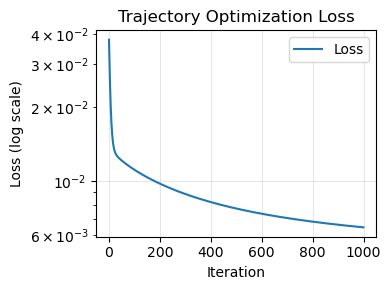

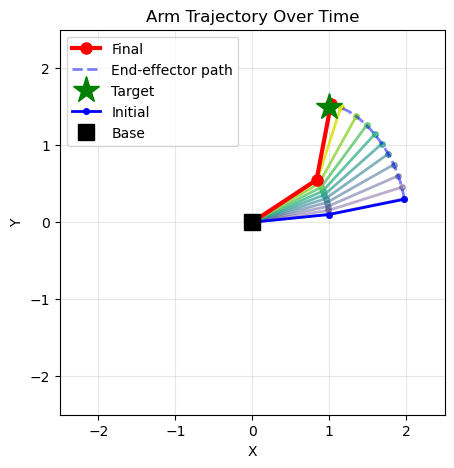

Trajectory Metrics:
  Total joint movement: 1.1782 radians
  Max velocity: 0.1116 rad/timestep
  Max acceleration: 0.0265 rad/timestep²
  Smoothness cost: 0.0018 (lower is better)


In [234]:
# Visualize results
plot_loss_curve(loss_hist, "Trajectory Optimization Loss")
plt.show()

plot_trajectory_sequence(theta_traj, LENGTHS, target, theta_init)
plt.show()

analyze_trajectory_metrics(theta_traj)

<div class="alert alert-info">
Q12: Run trajectory optimization with three different energy weights: $\lambda_{energy} = [0.01, 0.1, 1.0]$ (keep $\lambda_{smooth}=0.05$ fixed). For each, visualize the resulting trajectory and report the total joint movement (sum of velocity magnitudes). How does increasing the energy penalty affect the motion? Does the arm still reach the target?
</div>


Optimizing trajectory with λ_energy=0.01
Iteration 0: Loss = 0.035503
Iteration 100: Loss = 0.007562
Iteration 200: Loss = 0.005756
Iteration 300: Loss = 0.004472
Iteration 400: Loss = 0.003557
Iteration 500: Loss = 0.002904
Iteration 600: Loss = 0.002438
Iteration 700: Loss = 0.002102
Iteration 800: Loss = 0.001857
Iteration 900: Loss = 0.001674
Trajectory Metrics:
  Total joint movement: 1.2088 radians
  Max velocity: 0.1691 rad/timestep
  Max acceleration: 0.0592 rad/timestep²
  Smoothness cost: 0.0079 (lower is better)
End position: [1.01092899 1.51883072]
Distance to target: 0.02177242927951956

Optimizing trajectory with λ_energy=0.1
Iteration 0: Loss = 0.037871
Iteration 100: Loss = 0.011118
Iteration 200: Loss = 0.009756
Iteration 300: Loss = 0.008848
Iteration 400: Loss = 0.008200
Iteration 500: Loss = 0.007717
Iteration 600: Loss = 0.007347
Iteration 700: Loss = 0.007055
Iteration 800: Loss = 0.006819
Iteration 900: Loss = 0.006625
Trajectory Metrics:
  Total joint movement:

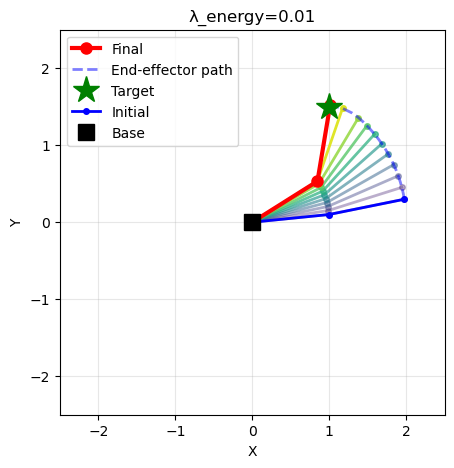

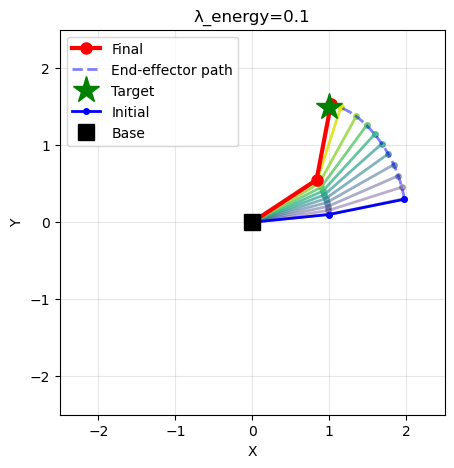

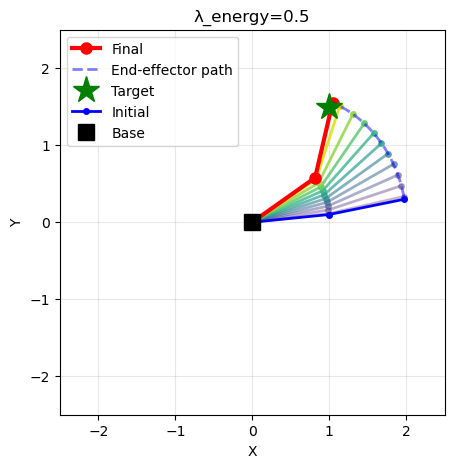

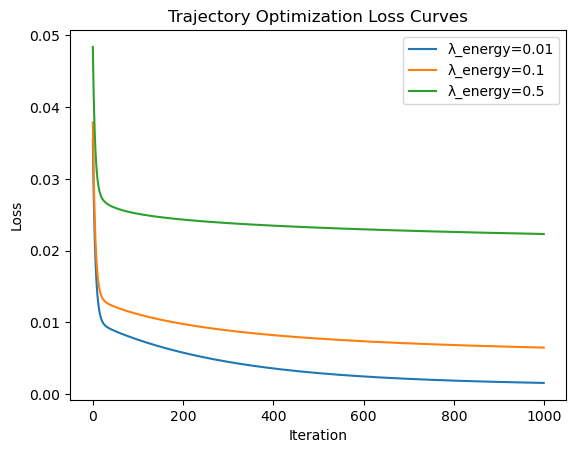

In [235]:
lambda_energy_list = [0.01, 0.1, 0.5]
T = 20
loss_histories = []
for i, lambda_energy in enumerate(lambda_energy_list):
    print(f"\nOptimizing trajectory with λ_energy={lambda_energy}")
    theta_traj, loss_hist = gradient_descent_trajectory(
        theta_init, target, LENGTHS,
        T=T, learning_rate=0.01, n_iterations=1000,
        lambda_energy=lambda_energy, lambda_smooth=0.05
    )
    plot_trajectory_sequence(theta_traj, LENGTHS, target,
                             title=f"λ_energy={lambda_energy}", theta_init=theta_init)
    analyze_trajectory_metrics(theta_traj)
    loss_histories.append(loss_hist)

    end_eff = forward_kinematics_numpy(theta_traj[-1], LENGTHS)
    print("End position:", end_eff)
    print("Distance to target:", np.linalg.norm(end_eff - target))

plt.figure()
for i, lambda_energy in enumerate(lambda_energy_list):
    plt.plot(loss_histories[i], label=f"λ_energy={lambda_energy}")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Trajectory Optimization Loss Curves")
plt.legend()
plt.show()


A12: As the energy penalty increases, the arm's motion becomes smoother and reduce joint movements (Smoothness cost and total joint movement decrease with λ_energy). However, with a very high energy penalty, the arm may struggle to reach the target effectively, as it prioritizes minimizing energy consumption over reaching the target quickly. So it may not reach the target as closely as with lower energy penalties.

<div class="alert alert-info">
Q13: Compare trajectory optimization using SGD with Momentum vs Adam. Use $T=20$, $\lambda_{energy}=0.1$, $\lambda_{smooth}=0.05$. Which converges faster? Plot both trajectories side-by-side. Do they find qualitatively different solutions (different motion strategies)?
</div>

In [222]:
def sgd_momentum_trajectory(theta_init: np.ndarray,
                                target: np.ndarray,
                                lengths: np.ndarray,
                                T: int = 20,
                                learning_rate: float = 0.01,
                                beta: float = 0.9,
                                n_iterations: int = 1000,
                                lambda_energy: float = 0.1,
                                lambda_smooth: float = 0.05):
    # Initialize trajectory: linear interpolation from init to a guess
    target_angles = theta_init + 0.5  # Simple guess for final angles
    theta_sequence = jnp.array([
        theta_init + (target_angles - theta_init) * t / (T - 1)
        for t in range(T)
    ])
    
    lengths_jax = jnp.array(lengths)
    target_jax = jnp.array(target)
    v = jnp.zeros_like(theta_sequence)
    
    loss_history = []
    
    for iteration in range(n_iterations):
        # Compute loss and gradient
        loss_val = loss_trajectory(theta_sequence, lengths_jax, target_jax, theta_init,
                                   lambda_energy, lambda_smooth)
        gradient = grad_loss_trajectory(theta_sequence, lengths_jax, target_jax, theta_init,
                                       lambda_energy, lambda_smooth)
        
        # Update trajectory
        v = beta * v + gradient
        theta_sequence = theta_sequence - learning_rate * v
        
        loss_history.append(float(loss_val))
        
        if iteration % 100 == 0:
            print(f"Iteration {iteration}: Loss = {loss_val:.6f}")
    
    return np.array(theta_sequence), np.array(loss_history)

In [223]:
def adam_trajectory(theta_init: np.ndarray,
                                target: np.ndarray,
                                lengths: np.ndarray,
                                T: int = 20,
                                learning_rate: float = 0.01,
                                beta1: float = 0.9,
                                beta2: float = 0.999,
                                n_iterations: int = 1000,
                                lambda_energy: float = 0.1,
                                lambda_smooth: float = 0.05):
    # Initialize trajectory: linear interpolation from init to a guess
    target_angles = theta_init + 0.5  # Simple guess for final angles
    theta_sequence = jnp.array([
        theta_init + (target_angles - theta_init) * t / (T - 1)
        for t in range(T)
    ])
    
    lengths_jax = jnp.array(lengths)
    target_jax = jnp.array(target)
    v = jnp.zeros_like(theta_sequence)
    m = jnp.zeros_like(theta_sequence)
    
    loss_history = []
    
    for i in range(n_iterations):
        # Compute loss and gradient
        loss_val = loss_trajectory(theta_sequence, lengths_jax, target_jax, theta_init,
                                   lambda_energy, lambda_smooth)
        gradient = grad_loss_trajectory(theta_sequence, lengths_jax, target_jax, theta_init,
                                       lambda_energy, lambda_smooth)
        
        # Update trajectory
        m = beta1 * m + (1 - beta1) * gradient
        v = beta2 * v + (1 - beta2) * gradient**2
        m_hat = m / (1 - beta1**(i + 1))
        v_hat = v / (1 - beta2**(i + 1))
        # TODO: Update 
        # theta using gradient descent rule
        # theta = ?
        theta_sequence = theta_sequence - learning_rate * m_hat / (jnp.sqrt(v_hat) + 1e-8)
        
        loss_history.append(float(loss_val))
        
        if i % 100 == 0:
            print(f"Iteration {i}: Loss = {loss_val:.6f}")
    
    return np.array(theta_sequence), np.array(loss_history)


Optimizing trajectory with SGD with Momentum
Iteration 0: Loss = 0.037871
Iteration 100: Loss = 0.006513
Iteration 200: Loss = 0.005637
Iteration 300: Loss = 0.005282
Iteration 400: Loss = 0.005077
Iteration 500: Loss = 0.004939
Iteration 600: Loss = 0.004839
Iteration 700: Loss = 0.004761
Iteration 800: Loss = 0.004698
Iteration 900: Loss = 0.004647
Trajectory Metrics:
  Total joint movement: 1.2098 radians
  Max velocity: 0.0645 rad/timestep
  Max acceleration: 0.0035 rad/timestep²
  Smoothness cost: 0.0001 (lower is better)
End position: [1.0079501  1.51009911]
Distance to target: 0.012852864683459097

Optimizing trajectory with Adam
Iteration 0: Loss = 0.037871
Iteration 100: Loss = 0.004424
Iteration 200: Loss = 0.004256
Iteration 300: Loss = 0.004255
Iteration 400: Loss = 0.004255
Iteration 500: Loss = 0.004255
Iteration 600: Loss = 0.004256
Iteration 700: Loss = 0.004255
Iteration 800: Loss = 0.004258
Iteration 900: Loss = 0.004255
Trajectory Metrics:
  Total joint movement: 1.

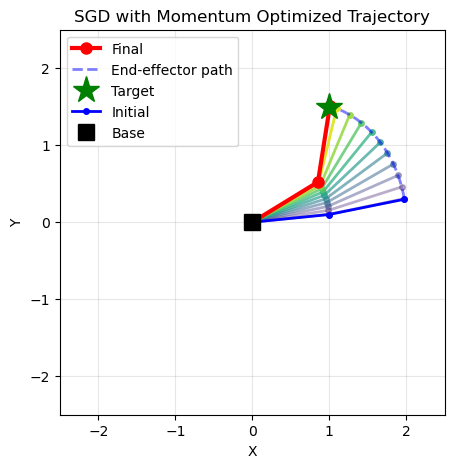

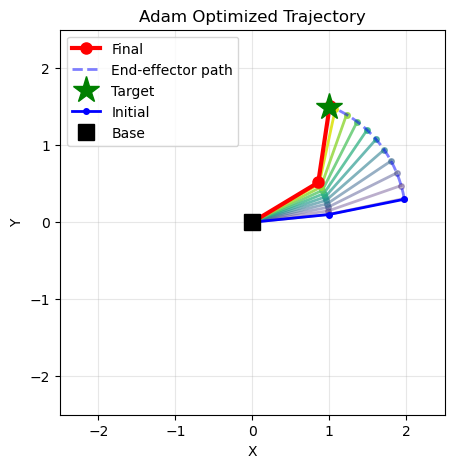

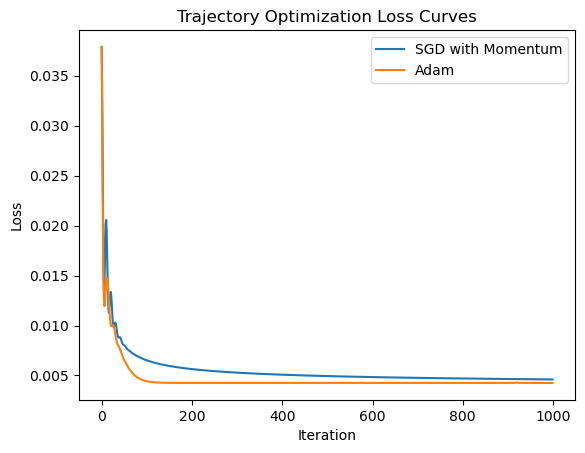

In [236]:
optimizers = {
    "SGD with Momentum": sgd_momentum_trajectory,
    "Adam": adam_trajectory
}
T = 20
loss_histories = []
for key, optimizer in optimizers.items():
    print(f"\nOptimizing trajectory with {key}")
    theta_traj, loss_hist = optimizer(
        theta_init, target, LENGTHS,
        T=T, learning_rate=0.01, n_iterations=1000,
        lambda_energy=0.1, lambda_smooth=0.05
    )
    
    plot_trajectory_sequence(theta_traj, LENGTHS, target,
                             title=f"{key} Optimized Trajectory", theta_init=theta_init)
    
    analyze_trajectory_metrics(theta_traj)

    loss_histories.append((key, loss_hist))
    end_eff = forward_kinematics_numpy(theta_traj[-1], LENGTHS)
    print("End position:", end_eff)
    print("Distance to target:", np.linalg.norm(end_eff - target))

plt.figure()
for key, loss_hist in loss_histories:
    plt.plot(loss_hist, label=key)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Trajectory Optimization Loss Curves")
plt.legend()
plt.show()

A13: Adam converges faster than SGD with Momentum and they find qualitatively the same solutions.

<div class="alert alert-info">
Q14: The trajectory optimization problem has $T \times 2$ parameters (40 parameters for $T=20$). This is similar to optimizing a small neural network. Based on your experiments, which optimizer (GD, Momentum, Adam) would you recommend for optimizing trajectories? How might your answer change if $T=100$ (200 parameters)?
</div>


Optimizing trajectory with SGD
Iteration 0: Loss = 0.035745
Iteration 100: Loss = 0.008426
Iteration 200: Loss = 0.006975
Iteration 300: Loss = 0.006009
Iteration 400: Loss = 0.005321
Iteration 500: Loss = 0.004811
Iteration 600: Loss = 0.004420
Iteration 700: Loss = 0.004112
Iteration 800: Loss = 0.003865
Iteration 900: Loss = 0.003661
Trajectory Metrics:
  Total joint movement: 1.2077 radians
  Max velocity: 0.0922 rad/timestep
  Max acceleration: 0.0273 rad/timestep²
  Smoothness cost: 0.0019 (lower is better)
End position: [1.01929942 1.53164923]
Distance to target: 0.03706941334057901

Optimizing trajectory with SGD with Momentum
Iteration 0: Loss = 0.035745
Iteration 100: Loss = 0.003544
Iteration 200: Loss = 0.002630
Iteration 300: Loss = 0.002259
Iteration 400: Loss = 0.002046
Iteration 500: Loss = 0.001903
Iteration 600: Loss = 0.001798
Iteration 700: Loss = 0.001718
Iteration 800: Loss = 0.001653
Iteration 900: Loss = 0.001600
Trajectory Metrics:
  Total joint movement: 1.23

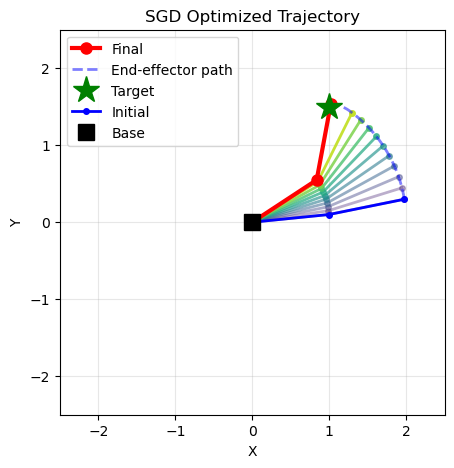

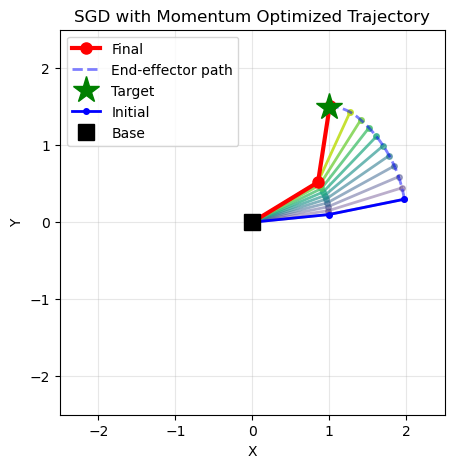

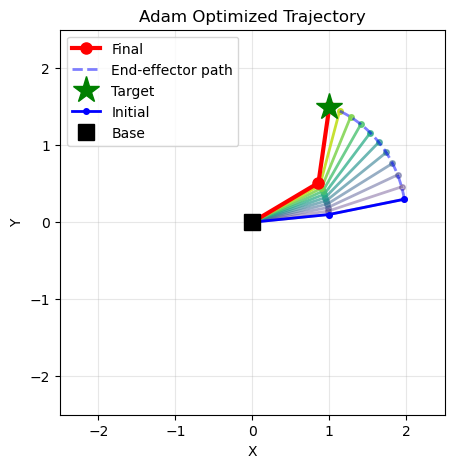

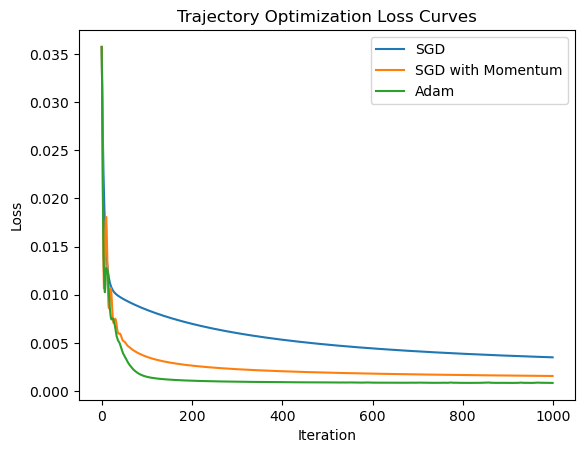

In [237]:
optimizers = {
    "SGD": gradient_descent_trajectory,
    "SGD with Momentum": sgd_momentum_trajectory,
    "Adam": adam_trajectory
}
T = 100
loss_histories = []
for key, optimizer in optimizers.items():
    print(f"\nOptimizing trajectory with {key}")
    theta_traj, loss_hist = optimizer(
        theta_init, target, LENGTHS,
        T=T, learning_rate=0.01, n_iterations=1000,
        lambda_energy=0.1, lambda_smooth=0.05
    )
    plot_trajectory_sequence(theta_traj, LENGTHS, target,
                             title=f"{key} Optimized Trajectory", theta_init=theta_init)
    analyze_trajectory_metrics(theta_traj)
    loss_histories.append((key, loss_hist))
    end_eff = forward_kinematics_numpy(theta_traj[-1], LENGTHS)
    print("End position:", end_eff)
    print("Distance to target:", np.linalg.norm(end_eff - target))

plt.figure()
for key, loss_hist in loss_histories:
    plt.plot(loss_hist, label=key)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.title("Trajectory Optimization Loss Curves")
plt.legend()
plt.show()

A14: Based on the experiments, Adam is recommended for optimizing trajectories due to its faster convergence and adaptive learning rates. If T=100 (200 parameters), Adam's advantages would likely become even more pronounced, as it can better handle the increased complexity and dimensionality of the optimization problem compared to GD and Momentum.

<div class="alert alert-info">
Q15: Gradient-free methods can also optimize trajectories! However, with $T \times 2$ parameters, the search space becomes much larger. Implement ES for trajectory optimization. Use a smaller population size initially (N=10) and $T=10$ timesteps to keep computation manageable. Compare sample efficiency (total function evaluations) with Adam. When might ES be preferred despite being less sample-efficient?
</div>

In [238]:
def gradient_free_trajectory(theta_init: np.ndarray,
                                target: np.ndarray,
                                lengths: np.ndarray,
                                T: int = 20,
                                learning_rate: float = 0.01,
                                n_iterations: int = 1000,
                                pop_size: int = 10,
                                lambda_energy: float = 0.1,
                                lambda_smooth: float = 0.05):
    # Initialize trajectory: linear interpolation from init to a guess
    target_angles = theta_init + 0.5  # Simple guess for final angles
    theta_sequence = jnp.array([
        theta_init + (target_angles - theta_init) * t / (T - 1)
        for t in range(T)
    ])
    
    lengths_jax = jnp.array(lengths)
    target_jax = jnp.array(target)
    
    loss_fn = lambda th_seq: loss_trajectory(th_seq, lengths_jax, target_jax,
                                            theta_init, lambda_energy, lambda_smooth)
    
    loss_history = []
    
    for iteration in range(n_iterations):
        noise = jax.random.normal(jax.random.PRNGKey(iteration), (pop_size, T, 2)) * 0.1
        theta_pop = theta_sequence + noise
        losses = jnp.array([loss_fn(th_seq) for th_seq in theta_pop])
        weights = jax.nn.softmax(-losses/0.1)
        grad = jnp.sum(weights[:, None, None] * noise, axis=0)
        theta_sequence = theta_sequence + learning_rate * grad
        
        loss_val = loss_fn(theta_sequence)
        loss_history.append(float(loss_val))
        
        if iteration % (n_iterations // 10) == 0:
            print(f"Iteration {iteration}: Loss = {loss_val:.6f}")
    
    return np.array(theta_sequence), np.array(loss_history)

Iteration 0: Loss = 0.039983
Iteration 100: Loss = 0.020563
Iteration 200: Loss = 0.017411
Iteration 300: Loss = 0.018162
Iteration 400: Loss = 0.017043
Iteration 500: Loss = 0.014992
Iteration 600: Loss = 0.013665
Iteration 700: Loss = 0.012762
Iteration 800: Loss = 0.016968
Iteration 900: Loss = 0.016336
Trajectory Metrics:
  Total joint movement: 1.2218 radians
  Max velocity: 0.1495 rad/timestep
  Max acceleration: 0.1106 rad/timestep²
  Smoothness cost: 0.0439 (lower is better)
End position: [1.00912625 1.52131909]
Distance to target: 0.02319034325570323


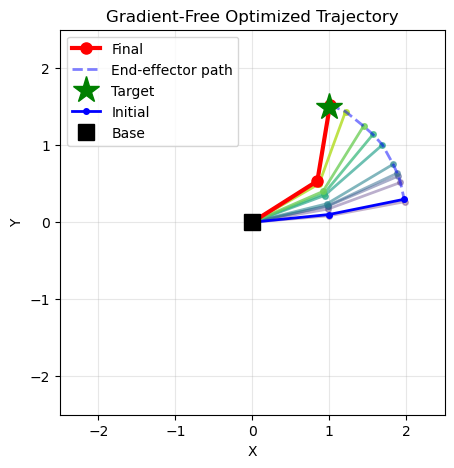

In [239]:
T=10
theta_traj, loss_hist = gradient_free_trajectory(
    theta_init, target, LENGTHS,
    T=T, learning_rate=0.1, n_iterations=1000,
    pop_size=10, lambda_energy=0.1, lambda_smooth=0.05
)
plot_trajectory_sequence(theta_traj, LENGTHS, target,
                         title=f"Gradient-Free Optimized Trajectory", theta_init=theta_init)
analyze_trajectory_metrics(theta_traj)
end_eff = forward_kinematics_numpy(theta_traj[-1], LENGTHS)
print("End position:", end_eff)
print("Distance to target:", np.linalg.norm(end_eff - target))

A15: Adam is more sample-efficient than ES for trajectory optimization, as it requires fewer function evaluations to reach a satisfactory solution. However, ES might be preferred in scenarios where the loss function is non-differentiable or has discontinuities, making gradient-based methods like Adam inapplicable. Additionally, ES can be more robust to noisy evaluations and can explore a broader search space, which may be beneficial in highly complex optimization landscapes.